In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Greenland = pd.read_excel(filepath, sheet_name='Greenland-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Greenland)
fp.date_time(Greenland)

,Extent,Date
0,1076123.146,1979-01-01
1,1099248.063,1979-02-01
2,1036964.901,1979-03-01
3,958927.937,1979-04-01
4,823812.694,1979-05-01
...,...,...
533,721350.515,2023-06-01
534,459033.164,2023-07-01
535,282045.909,2023-08-01
536,270397.608,2023-09-01


In [5]:
scaler = MinMaxScaler()
Greenland['Extent'] = scaler.fit_transform(Greenland['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 7
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Greenland['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((520, 12, 1), (520,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Greenland_model_LT7/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 18s 224ms/step - loss: 0.2744 - root_mean_squared_error: 0.5238 - val_loss: 0.1015 - val_root_mean_squared_error: 0.3186
Epoch 2/50
53/53 [==============================] - 10s 200ms/step - loss: 0.1124 - root_mean_squared_error: 0.3353 - val_loss: 0.0364 - val_root_mean_squared_error: 0.1907
Epoch 3/50
53/53 [==============================] - 10s 200ms/step - loss: 0.0405 - root_mean_squared_error: 0.2014 - val_loss: 0.0312 - val_root_mean_squared_error: 0.1768
Epoch 4/50
53/53 [==============================] - 2s 30ms/step - loss: 0.0394 - root_mean_squared_error: 0.1984 - val_loss: 0.0326 - val_root_mean_squared_error: 0.1806
Epoch 5/50
53/53 [==============================] - 10s 200ms/step - loss: 0.0380 - root_mean_squared_error: 0.1948 - val_loss: 0.0305 - val_root_mean_squared_error: 0.1747
Epoch 6/50
53/53 [==============================] - 11s 202ms/step - loss: 0.0375 - root_mean_squared_error: 0.1936 - val_loss: 0.0285 - 

Epoch 32/50
53/53 [==============================] - 2s 31ms/step - loss: 0.0131 - root_mean_squared_error: 0.1143 - val_loss: 0.0171 - val_root_mean_squared_error: 0.1306
Epoch 33/50
53/53 [==============================] - 2s 31ms/step - loss: 0.0141 - root_mean_squared_error: 0.1187 - val_loss: 0.0180 - val_root_mean_squared_error: 0.1342
Epoch 34/50
53/53 [==============================] - 2s 29ms/step - loss: 0.0133 - root_mean_squared_error: 0.1153 - val_loss: 0.0150 - val_root_mean_squared_error: 0.1223
Epoch 35/50
53/53 [==============================] - 2s 31ms/step - loss: 0.0124 - root_mean_squared_error: 0.1114 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1190
Epoch 36/50
53/53 [==============================] - 10s 184ms/step - loss: 0.0139 - root_mean_squared_error: 0.1181 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1142
Epoch 37/50
53/53 [==============================] - 2s 30ms/step - loss: 0.0125 - root_mean_squared_error: 0.1119 - val_loss: 0.0140 - va

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

4.440709845225016 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

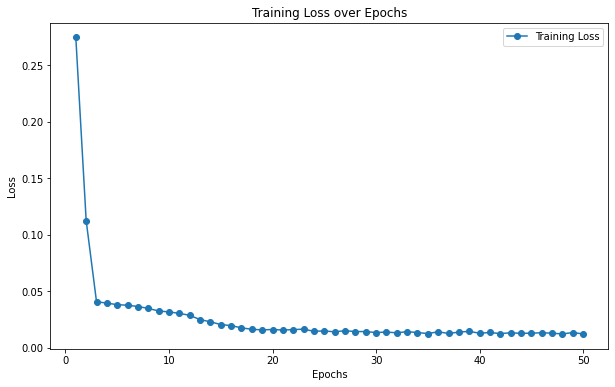

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

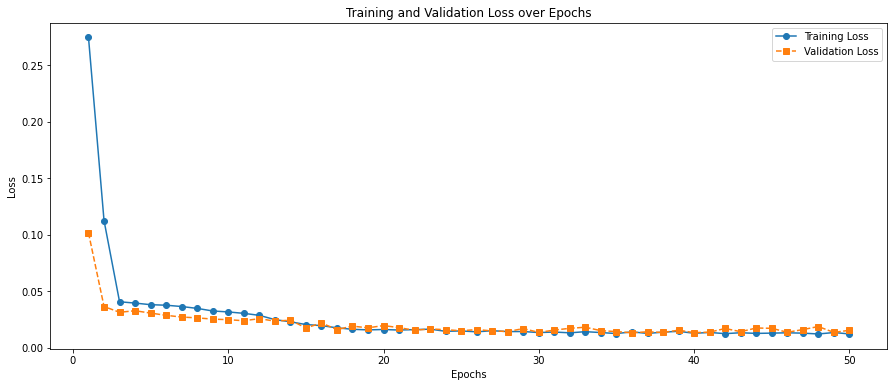

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Greenland_model_LT7/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 0s/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.10812227248940068
MAE : 0.0833918363875092


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,481962.25000,547183.986
1,565770.50000,584596.262
2,629493.75000,584830.109
3,663252.25000,641562.292
4,671653.81250,734946.437
5,643864.25000,777596.225
6,586594.18750,687087.673
7,518940.96875,622337.816
8,455393.12500,467232.074
9,399394.00000,297495.641


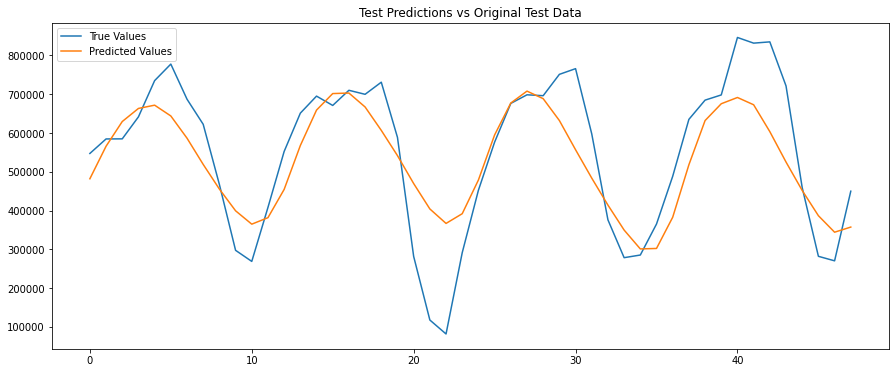

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 14ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

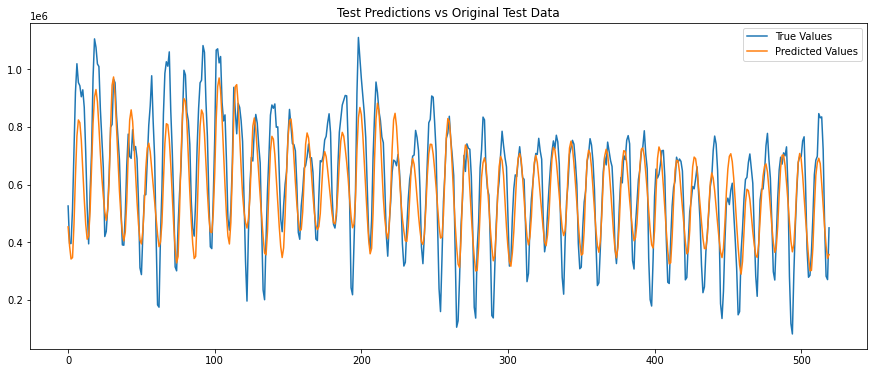

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()